# Re-do for larger datasets

In [23]:
import time
import bz2
import json
import pickle
import gc

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [25]:
# load random sample from file given ids
def load_sample_from_file(path, year, month, ids):
    # make ids a set for quicker lookup
    ids = set(ids)

    # loop through file and save comments with id=id with probability p
    sample = []
    with bz2.BZ2File(f'{path}RC_{year}-{month}.bz2', 'rb') as f:
        for line in f:
            entry = json.loads(line)
            if entry['id'] in ids:
                sample.append(entry['body'])
    
    return sample

def load_npz(path, year, month, key):
    with open(f'{path}{key}/{key}_{year}-{month}.npz', 'rb') as f:
        array = np.load(f)[key]
    return array

def load_metadata(path, year, month):
    with open(f'{path}metadata/metadata_{year}-{month}.pkl', 'rb') as f:
        metadata = pickle.load(f)
        metadata = pd.DataFrame(metadata, columns=['k', 'author', 'id', 'utc'])
    return metadata

## Examine cluster text content

In [18]:
DATA_PATH = '/sciclone/data10/twford/reddit/reddit/comments/'
BASE_PATH = '/sciclone/geograd/stmorse/reddit/'

In [32]:
# pick cluster of interest
coi = 0
sample_rate = .1
seed = 123

# time period
# years = [2007, 2008, 2009, 2010, 2011]
# months = [f'{m:02}' for m in range(1,13)]
years = [2007]
months = ['01']

# load sample of sentence + author from across all files
sample_sentences = []
sample_embeddings = []
t0 = time.time()
for year, month in [(yr, mo) for yr in years for mo in months]:
    print(f'Sampling {year}-{month} ... ({time.time()-t0:.2f})')

    # get indices of this label
    print(f'> Loading complete labels ... ', end='')
    labels = load_npz(BASE_PATH, year, month, 'labels')
    idx = np.where(labels==coi)[0]
    del labels
    print(f'total {len(idx)}  ({time.time()-t0:.2f})')

    # get corresponding metadata
    print(f'> Loading complete metadata ... ', end='')
    metadata = load_metadata(BASE_PATH, year, month)
    ids = metadata.iloc[idx, 2]
    print(f'total {len(ids)} ({time.time()-t0:.2f})')

    # choosing sample idx

    # create RNG with seed
    rng = np.random.default_rng(seed=seed)

    # sample_idx is indices to idx (sorted)
    sample_idx = rng.choice(len(idx), size=int(sample_rate * len(idx)), replace=False)
    sample_idx = np.sort(sample_idx)

    # sampled ids within ids
    sample_ids = ids.iloc[sample_idx]

    # sample sentences from these ids
    print(f'> Sampling sentences ... ')
    sample = load_sample_from_file(DATA_PATH, year, month, sample_ids)
    sample_sentences.extend(sample)
    print(f'  total {len(sample_sentences)} ({time.time()-t0:.2f})')

    # load corresponding embeddings
    # note we need to use total idx, but only sampled ones
    print(f'> Loading embeddings ... ', end='')
    embeddings = load_npz(BASE_PATH, year, month, 'embeddings')[idx[sample_idx]]
    sample_embeddings.append(embeddings)
    print(f'total {len(embeddings)} ({time.time()-t0:.2f})')
    del embeddings

    gc.collect()

sample_embeddings = np.vstack(sample_embeddings)
        
print(len(sample_sentences), sample_embeddings.shape)

Sampling 2007-01 ... (0.00)
> Loading complete labels ... total 4119  (0.00)
> Loading complete metadata ... total 4119 (0.13)
> Sampling sentences ... 


  total 411 (2.53)
> Loading embeddings ... total 411 (2.85)
411 (411, 384)


In [33]:
with open(f'{BASE_PATH}mbkm_cc_20_2007_2011.npz', 'rb') as f:
    cluster_centers = np.load(f)['cc']
cluster_centers.shape

(20, 384)

In [ ]:
query_vector = cluster_centers[coi]
top_k = 10
distances = np.linalg.norm(sample_embeddings - query_vector, axis=1)
closest_points = np.argsort(distances)[:top_k]

## Plot clusters

In [ ]:
# load sample embeddings from across all files
# load corresponding indices

<hr />

# Older:

In [1]:
import bz2 
import json
import pickle
import sys

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from joblib import dump, load

In [2]:
LOAD_PATH = '/sciclone/data10/twford/reddit/reddit/'
SAVE_PATH = '/sciclone/geograd/stmorse/reddit/'

# User participation

In [3]:
# load all metadata and labels for a period into a DataFrame

years = [2007, 2008, 2009]
months = ['01', '02', '03', '04', '05', '06', 
          '07', '08', '09', '10', '11', '12']
# years = [2007]
# months = ['01', '02']
yr_mo = [(yr, mo) for yr in years for mo in months]

# initiate an empty DataFrame
col_names = ['k', 'author', 'id', 'utc', 'year', 'month', 'cluster']
df = pd.DataFrame(columns=col_names)

# iterate over by-month files
for year, month in yr_mo:
    print(f'Loading {year}-{month}...')

    # load metadata
    fname1 = f'{SAVE_PATH}metadata/metadata_{year}-{month}.pkl'
    with open(fname1, 'rb') as f:
        tdf = pd.DataFrame(pickle.load(f), columns=col_names[:4])
        tdf['year'] = year
        tdf['month'] = month
    
    # load labels
    fname2 = f'{SAVE_PATH}labels/labels_{year}-{month}.npz'
    with open(fname2, 'rb') as f:
        labels = np.load(f)['labels']
        tdf['cluster'] = labels
    
    # append to df
    df = pd.concat([df, tdf], ignore_index=True)

# fix dtypes
df['k'] = df['k'].astype(int)
df['author'] = df['author'].astype(str)
df['id'] = df['id'].astype(str)
df['year'] = df['year'].astype(int)
df['month'] = df['month'].astype(int)
df['cluster'] = df['cluster'].astype(int)

print('Complete.')
    

Loading 2007-01...
Loading 2007-02...
Loading 2007-03...
Loading 2007-04...
Loading 2007-05...
Loading 2007-06...
Loading 2007-07...
Loading 2007-08...
Loading 2007-09...
Loading 2007-10...
Loading 2007-11...
Loading 2007-12...
Loading 2008-01...
Loading 2008-02...
Loading 2008-03...
Loading 2008-04...
Loading 2008-05...
Loading 2008-06...
Loading 2008-07...
Loading 2008-08...
Loading 2008-09...
Loading 2008-10...
Loading 2008-11...
Loading 2008-12...
Loading 2009-01...
Loading 2009-02...
Loading 2009-03...
Loading 2009-04...
Loading 2009-05...
Loading 2009-06...
Loading 2009-07...
Loading 2009-08...
Loading 2009-09...
Loading 2009-10...
Loading 2009-11...
Loading 2009-12...
Complete.


In [5]:
sys.getsizeof(df)

4099742472

In [7]:
4099742472 / (1024*1024*1024)

3.8181827142834663

In [8]:
df.head()

,k,author,id,utc,year,month,cluster
0,0,almkglor,cwl3r,1167609605,2007,1,6
1,1,hitsman,cwl3s,1167609743,2007,1,13
2,2,raldi,cwl3t,1167609769,2007,1,2
3,3,neoform,cwl3w,1167609826,2007,1,2
4,4,hotmama420,cwl3x,1167609856,2007,1,5


In [9]:
# get series with author count
author_counts = df['author'].value_counts()

# trim df to where authors have at least N comments
N = 20
authors_to_keep = author_counts[author_counts >= N].index
trim_df = df.query('author in @authors_to_keep')

trim_df.head()

,k,author,id,utc,year,month,cluster
0,0,almkglor,cwl3r,1167609605,2007,1,6
1,1,hitsman,cwl3s,1167609743,2007,1,13
2,2,raldi,cwl3t,1167609769,2007,1,2
3,3,neoform,cwl3w,1167609826,2007,1,2
5,5,freshhawk,cwl42,1167609899,2007,1,1


In [10]:
len(trim_df)

19145159

In [13]:
len(author_counts), len(authors_to_keep), len(df), len(trim_df)

(384377, 69705, 20104937, 19145159)

In [14]:
19145159 / 20104937

0.9522615763481378

In [15]:
33*6

198

In [11]:
223 / 1024, 1.3/(223/1024)

(0.2177734375, 5.969506726457399)

In [16]:
# create a DataFrame of cluster counts for each user
user_clusters = trim_df.groupby(['author', 'cluster']).size().unstack(fill_value=0)

# add a column with total count of comments for each user
user_clusters['total'] = user_clusters.sum(axis=1)

# normalize each cluster count by the total count
n_clusters = df['cluster'].max()
for i in range(n_clusters+1):
    user_clusters[i] = user_clusters[i] / user_clusters['total']

user_clusters.head()

cluster,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,total
author,,,,,,,,,,,,,,,,
---------------,0.291667,0.083333,0.041667,0.083333,0.041667,0.000000,0.083333,0.000000,0.125000,0.000000,0.000000,0.083333,0.041667,0.000000,0.125000,24
---sniff---,0.010791,0.031175,0.040767,0.169065,0.154676,0.212230,0.101918,0.034772,0.028777,0.017986,0.059952,0.010791,0.051559,0.068345,0.007194,834
--GOD--,0.000000,0.076923,0.076923,0.307692,0.038462,0.076923,0.115385,0.076923,0.000000,0.000000,0.000000,0.192308,0.000000,0.000000,0.038462,26
--cough--,0.000000,0.021739,0.000000,0.184783,0.010870,0.054348,0.065217,0.021739,0.119565,0.000000,0.010870,0.000000,0.489130,0.000000,0.021739,92
-11,0.000000,0.100000,0.000000,0.000000,0.025000,0.200000,0.000000,0.250000,0.025000,0.100000,0.000000,0.000000,0.000000,0.275000,0.025000,40


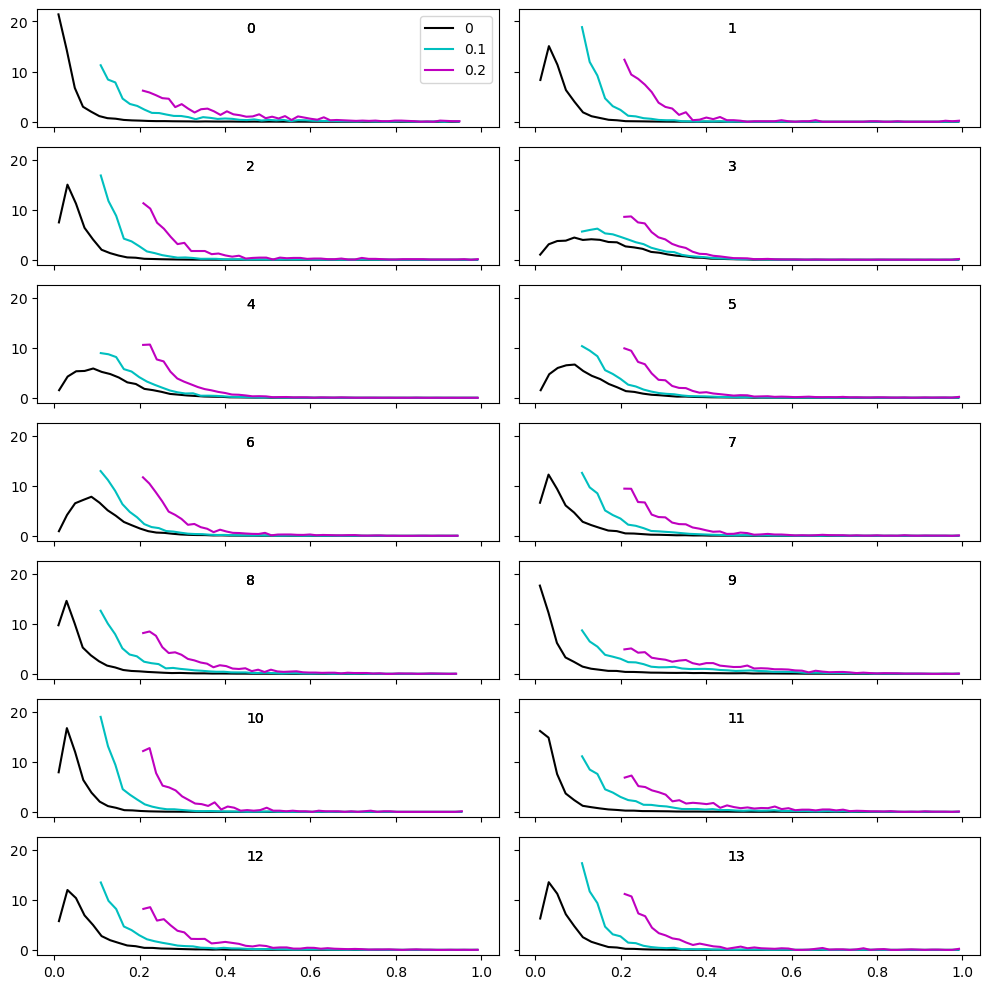

In [26]:
fig, axs = plt.subplots(7,2, figsize=(10,10), sharex=True, sharey=True)

# minimum participation in the cluster
minp = 0.2

for minp, color in zip([0, 0.1, 0.2], ['k', 'c', 'm']):
    for k, ax in enumerate(axs.ravel()):
        # create temp df with users at least minp in this cluster 
        # just keep column k
        tdf = user_clusters[user_clusters[k] > minp]

        # ax.hist(tdf[k], bins=50, density=True, alpha=0.8)
        hist, bins = np.histogram(tdf[k], bins=50, density=True)
        bin_centers = (bins[:-1] + bins[1:]) / 2
        ax.plot(bin_centers, hist, color=color, label=minp)
        ax.text(0.45, 18, k)

        if k==0:
            ax.legend()

# axs[0].legend()
plt.tight_layout()
plt.show()

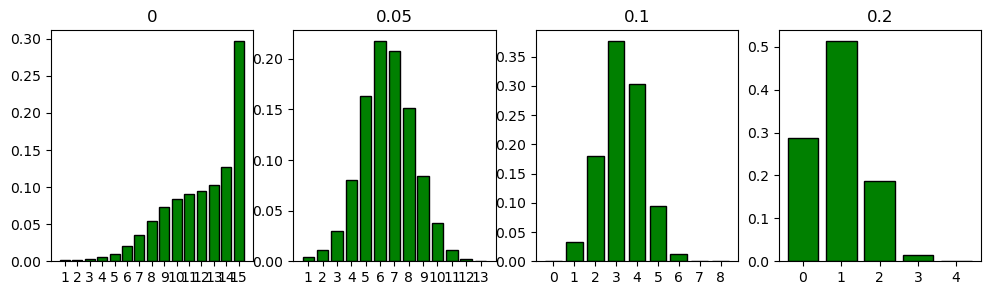

In [27]:
fig, axs = plt.subplots(1,4, figsize=(12,3))

for ax, minp in zip(axs.ravel(), [0, 0.05, 0.1, 0.2]):
    nonzero = (user_clusters.iloc[:,:-1] > minp)\
        .sum(axis=1)\
        .value_counts(normalize=True)\
        .sort_index()
    
    ax.bar(nonzero.index, nonzero.values, color='g', ec='k', lw=1)
    ax.set_xticks(nonzero.index)
    ax.set_title(minp)

plt.show()

# Examine clusters

In [37]:
def load_comments_from_file(year, month):
    filename = f'RC_{year}-{month}.bz2'
    
    try:
        with bz2.BZ2File(LOAD_PATH + 'comments/' + filename, 'rb') as file:
            for line in file:
                if len(line) < 10:
                    continue

                yield json.loads(line)
                    
    except FileNotFoundError:
        print(f'Error: {filename} not found')

In [30]:
cluster_model = load('/sciclone/geograd/stmorse/reddit/cm_mbkm_20241108.joblib')
cluster_model.cluster_centers_.shape

(15, 384)

In [31]:
cluster_centers = cluster_model.cluster_centers_

In [32]:
embeddings = None
with open(f'{SAVE_PATH}embeddings/embeddings_2008-10.npz', 'rb') as f:
    embeddings = np.load(f)['embeddings']
embeddings.shape

(535836, 384)

In [93]:
# load embedding
# get closest points to query vector
# check indices match cluster (in metadata)
query_vector = cluster_centers[3]

top_k = 10
distances = np.linalg.norm(embeddings - query_vector, axis=1)
closest_points = np.argsort(distances)[:top_k]

In [94]:
top_df = df.query('year == 2008 & month == 10 & k in @closest_points')
top_df

,k,author,id,utc,year,month,cluster
4905161,4113,dave,c05nmvb,1222838683,2008,10,3
4925258,24210,MisterEThoughts,c05o9t7,1222941489,2008,10,3
4958238,57190,Bbaily,c05pbcu,1223092654,2008,10,3
5002504,101456,dave,c05qqhm,1223370699,2008,10,3
5038325,137277,andyxyxy,c05ruuj,1223525192,2008,10,3
5040776,139728,Bbaily,c05rxn3,1223542336,2008,10,3
5067733,166685,SND_Crow,c05sshf,1223666903,2008,10,3
5262712,361664,ellieD,c05yzgd,1224671588,2008,10,3
5353805,452757,cheddarben,c061v6c,1225134048,2008,10,3
5436029,534981,jilseng4,c064ftq,1225493518,2008,10,3


In [ ]:
# load comments
data = []
for entry in load_comments_from_file(2008, 10):
    author = entry['author']
    if author != '[deleted]':
        data.append([entry['author'], entry['id'], entry['created_utc'], entry['body'][:50]])
data = pd.DataFrame(data, columns=['author', 'id', 'utc', 'body'])
data.head()

,author,id,utc,body
0,ohai,c05ni4r,1222819201,OMG thats like 100 jobs!!!!
1,Facepuncher,c05ni4s,1222819202,dun dun dunnnnnnn!
2,Mr_Smartypants,c05ni4t,1222819205,"Yeah, but he put his hand back up when the guy..."
3,MrKlaatu,c05ni4u,1222819207,"*""unusual""*??? \r\n...that's right you're not..."
4,emosorines,c05ni4v,1222819208,The Bush Administration defines condoms and ab...


In [95]:
data[data["id"].isin(top_df["id"])]

,author,id,utc,body
4113,dave,c05nmvb,1222838683,Haha!
24210,MisterEThoughts,c05o9t7,1222941489,haha!
57190,Bbaily,c05pbcu,1223092654,haha!
101456,dave,c05qqhm,1223370699,haha!
137277,andyxyxy,c05ruuj,1223525192,HA!
139728,Bbaily,c05rxn3,1223542336,haha!
166685,SND_Crow,c05sshf,1223666903,Haha!
361664,ellieD,c05yzgd,1224671588,haaa!
452757,cheddarben,c061v6c,1225134048,HA!
534981,jilseng4,c064ftq,1225493518,HA!


In [55]:
data.iloc[317063, 3]

'Oh oh, FUD from the pandering right-wing wackos, n'

# Deeper clustering

In [63]:
from sklearn.cluster import AgglomerativeClustering, Birch

In [60]:
with open(f'{SAVE_PATH}labels/labels_2008-10.npz', 'rb') as f:
    labels = np.load(f)['labels']
labels.shape

(535836,)

In [64]:
embeddings[labels==4].shape

(50794, 384)

In [65]:
dmodel = Birch(n_clusters=10).fit(embeddings[labels==5])

In [68]:
np.where(dmodel.labels_ == 1)[0].shape

(2103,)

In [82]:
for i in range(10):
    print(i, ' - ', np.where(dmodel.labels_ == i)[0].shape)

0  -  (10592,)
1  -  (2103,)
2  -  (7013,)
3  -  (3017,)
4  -  (6098,)
5  -  (3199,)
6  -  (2058,)
7  -  (2451,)
8  -  (710,)
9  -  (784,)


In [92]:
sublabels = dmodel.labels_

# this is the original indices in embeddings 
ix = np.where(labels==4)[0]

# this is the sublabel indices in the slice of embeddings
subix = np.where(sublabels==4)[0]

data.iloc[ix[subix],:].head(10)

,author,id,utc,body
262,Sqwirl,c05nifr,1222820436,That reminds me of that popular song from back...
494,scared1,c05nip4,1222821425,The only thing I can't stand more than Jim Rom...
578,aeon2012,c05nisp,1222821838,old but still funny
621,palalab,c05niua,1222821990,Why is his face all fuzzed out?
1076,bs9tmw,c05njd8,1222824145,I was thinking along the lines of Sacha Baron ...
1228,dubyabinlyin,c05njj4,1222824799,I think it's performance art... Like Bill O'R...
1249,bobcat,c05njjx,1222824894,"And that ""Under the Sea"" tune."
1488,wwabc,c05njtc,1222825961,"meh...maybe, like, three of them are 'Great', ..."
1572,pastanoose,c05njwi,1222826331,why did they let granpa outta the home?
1581,akinoyeshua,c05njwv,1222826370,that's awesome for you to have observed that a...
